<a href="https://colab.research.google.com/github/Ansalgadulu/python_ML/blob/main/AdEase_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

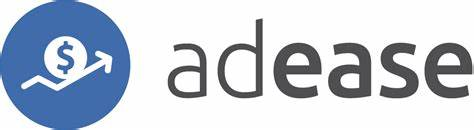

In [ ]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/Copy of train_1.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

#Transforming data into usable format
we want to do a forecast on each of the language,for that we have to the following steps


1.   get the language from page name
2.   get a mapping to convert language code into names
3.   dealing with rows for which we couldn't find any languages
4.   groupby language and find sum of visits each day




##Dealing with Nans

In [ ]:
df.isna().sum().sum()# the total number of Na values are as shown below

6192931

In [ ]:
num_zeros = (df.values == 0).sum()

# print the result
print(num_zeros)

1060418


In [ ]:
df[df['2015-07-01']==0].head()# checking if there are any zeroes in our data

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
50,Fate/Zero_zh.wikipedia.org_all-access_spider,0.0,2.0,5.0,3.0,21.0,7.0,27.0,22.0,7.0,...,13.0,9.0,9.0,17.0,12.0,15.0,23.0,19.0,24.0,10.0
69,Hisasi_zh.wikipedia.org_all-access_spider,0.0,1.0,4.0,1.0,5.0,3.0,1.0,5.0,5.0,...,3.0,10.0,3.0,6.0,4.0,6.0,8.0,11.0,9.0,7.0
92,MADTOWN_zh.wikipedia.org_all-access_spider,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,...,53.0,10.0,6.0,12.0,7.0,14.0,8.0,11.0,6.0,5.0
96,Mamamoo_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,26.0,29.0,44.0,46.0,41.0,22.0,22.0,65.0,46.0,32.0
100,Monstar_zh.wikipedia.org_all-access_spider,0.0,8.0,6.0,4.0,16.0,3.0,18.0,9.0,7.0,...,9.0,17.0,5.0,6.0,5.0,10.0,8.0,5.0,13.0,5.0


we can consider NaNs as days with no visits

In [ ]:
#replacing all nans with value 0
df.fillna('0',inplace=True)
df.isna().sum().sum()

0

our goal is to get the language each of these webpages belong to , I am scraping a wikipedia page to get the mapping using beautiful soup

In [ ]:
#our goal is to get the language each of these webpages belong to , I am scraping a wikipedia page to get the mapping using beautiful soup
import requests # library to handle requests
from bs4 import BeautifulSoup

In [ ]:
wikiurl="https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [ ]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
indiatable

<table class="wikitable sortable" id="Table">
<tbody><tr style="background-color:#EFEFEF">
<th>ISO language name
</th>
<th><span class="nowrap"><a href="/wiki/ISO_639-1" title="ISO 639-1">639-1</a></span>
</th>
<th><span class="nowrap"><a href="/wiki/ISO_639-2" title="ISO 639-2">639-2</a>/T</span>
</th>
<th><span class="nowrap">639-2/B</span>
</th>
<th><span class="nowrap"><a href="/wiki/ISO_639-3" title="ISO 639-3">639-3</a></span>
</th>
<th>Notes
</th></tr>
<tr>
<td id="ab"><a class="mw-redirect" href="/wiki/Abkhazian_language" title="Abkhazian language">Abkhazian</a></td>
<td><code><span class="plainlinks"><a class="external text" href="https://www.loc.gov/standards/iso639-2/php/langcodes_name.php?iso_639_1=ab" rel="nofollow">ab</a></span></code></td>
<td><code>abk</code></td>
<td><code>abk</code></td>
<td><code>abk</code></td>
<td>also known as Abkhaz
</td></tr>
<tr>
<td id="aa"><a href="/wiki/Afar_language" title="Afar language">Afar</a></td>
<td><code><span class="plainlinks"><a 

In [ ]:
df_lan=pd.read_html(str(indiatable))
# convert list to dataframe
df_lan=pd.DataFrame(df_lan[0])
df_lan.head()

,ISO language name,639-1,639-2/T,639-2/B,639-3,Notes
0,Abkhazian,ab,abk,abk,abk,also known as Abkhaz
1,Afar,aa,aar,aar,aar,NaN
2,Afrikaans,af,afr,afr,afr,NaN
3,Akan,ak,aka,aka,aka + 2,"macrolanguage, Twi is tw/twi, Fanti is fat"
4,Albanian,sq,sqi,alb,sqi + 4,"macrolanguage, called ""Albanian Phylozone"" in ..."


In [ ]:
df_lan=df_lan[['ISO language name','639-1']]

In [ ]:
df_lan.columns=['language','abb']
df_lan=df_lan[['abb','language']]
df_lan.head()# we got the language names and their short forms

,abb,language
0,ab,Abkhazian
1,aa,Afar
2,af,Afrikaans
3,ak,Akan
4,sq,Albanian


In [ ]:
#lets check what is there in Exog_Campaign_eng
df_exog=pd.read_csv('gdrive/My Drive/Copy of Exog_Campaign_eng')
df_exog.head(5)

,Exog
0,0
1,0
2,0
3,0
4,0


This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.


There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

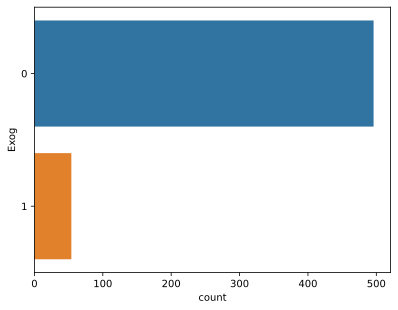

------------------------------------------------------
0    496
1     54
Name: Exog, dtype: int64


In [ ]:
sns.countplot(y=df_exog['Exog'])
plt.show()
print('------------------------------------------------------')
print(df_exog['Exog'].value_counts())

within the exog data out of 550 days provided to us 54 days had campaign and rest 496 were no campaign days

In [ ]:
import re
def extract_language(url):
    match = re.search(r'_([a-z]{2})\.', url)
    if match:
        return match.group(1)
    else:
        return None

df['Language'] = df['Page'].apply(extract_language)

In [ ]:
df.head()# we have created new column named language and source

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [ ]:
df["source"] = df["Page"].str.extract(r"\.(.*?)\.")



In [ ]:
df[df['Language'].isnull()]['Page'].tail(10)# lets check where there are no languages

84725    Wikimedia_Research_www.mediawiki.org_all-acces...
84726    Wikimedia_Research/Showcase_www.mediawiki.org_...
84727    Wikipedia_Zero_www.mediawiki.org_all-access_sp...
84728       Wikispeech_www.mediawiki.org_all-access_spider
84729    Zürich_Hackathon_2014_www.mediawiki.org_all-ac...
84730    help:contents_www.mediawiki.org_all-access_spider
84731    how_to_contribute_www.mediawiki.org_all-access...
84732        mediawiki_www.mediawiki.org_all-access_spider
84733     special:book_www.mediawiki.org_all-access_spider
84734    special:translate_www.mediawiki.org_all-access...
Name: Page, dtype: object

In [ ]:
df['Language'] = df['Language'].str.strip()
df_lan.set_index('abb',inplace=True)
df_lan=df_lan.to_dict()['language']
for key, value in df_lan.items():
    print(f"The data type of value for {key} is {type(value)}")

The data type of value for ab is <class 'str'>
The data type of value for aa is <class 'str'>
The data type of value for af is <class 'str'>
The data type of value for ak is <class 'str'>
The data type of value for sq is <class 'str'>
The data type of value for am is <class 'str'>
The data type of value for ar is <class 'str'>
The data type of value for an is <class 'str'>
The data type of value for hy is <class 'str'>
The data type of value for as is <class 'str'>
The data type of value for av is <class 'str'>
The data type of value for ae is <class 'str'>
The data type of value for ay is <class 'str'>
The data type of value for az is <class 'str'>
The data type of value for bm is <class 'str'>
The data type of value for ba is <class 'str'>
The data type of value for eu is <class 'str'>
The data type of value for be is <class 'str'>
The data type of value for bn is <class 'str'>
The data type of value for bi is <class 'str'>
The data type of value for bs is <class 'str'>
The data type

In [ ]:
print(df['Language'].dtype)
df['Language'] = df['Language'].astype(str)
print(df['Language'].dtype)


object
object


In [ ]:
temp=df['Language']
df['Language']=temp.map(df_lan)

In [ ]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,source
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,Chinese,wikipedia
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,Chinese,wikipedia
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,Chinese,wikipedia
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,Chinese,wikipedia
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,Chinese,wikipedia


In [ ]:
df['Language'].value_counts()

English               23980
Japanese              20431
German                18543
French                17802
Chinese               17229
Russian               15022
Spanish, Castilian    14073
Catalan, Valencian        3
Slovak                    3
Italian                   1
Name: Language, dtype: int64

In [ ]:
df['Language'].isna().sum()/len(df['Language'])# we hve 12 % missing in total

0.12391857330952759

In [ ]:
df["source"].value_counts().head(10)# we created a source column as well to check for the source, I think only the wikipedia pages have a language associated and the rest of them are most probably media pages.
#in this analysis we want to forecast for each language so , I would like to create a new df and lets name the language as media for all the other rows

wikipedia       125125
mediawiki         6889
wikimedia         4888
jpg_commons       2556
svg_commons        980
png_commons        608
JPG_commons        427
ogg_commons        261
ogv_commons        166
webm_commons       113
Name: source, dtype: int64

In [ ]:
df["source"].value_counts().nlargest(10).reset_index()

,index,source
0,wikipedia,125125
1,mediawiki,6889
2,wikimedia,4888
3,jpg_commons,2556
4,svg_commons,980
5,png_commons,608
6,JPG_commons,427
7,ogg_commons,261
8,ogv_commons,166
9,webm_commons,113


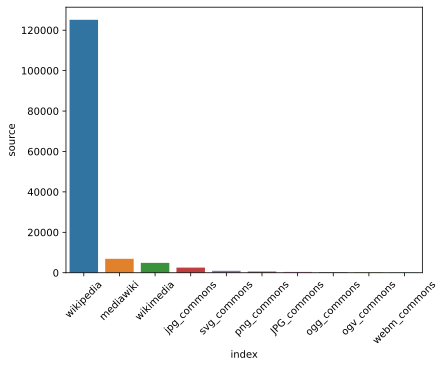

------------------------------------------------------
wikipedia       125125
mediawiki         6889
wikimedia         4888
jpg_commons       2556
svg_commons        980
png_commons        608
JPG_commons        427
ogg_commons        261
ogv_commons        166
webm_commons       113
Name: source, dtype: int64


In [ ]:
sns.barplot(y=df["source"].value_counts().nlargest(10).reset_index()['source'], x=df["source"].value_counts().nlargest(10).reset_index()['index'])
plt.xticks(rotation=45)
plt.show()
print('------------------------------------------------------')
print(df["source"].value_counts().nlargest(10))

Top sources of the articles are


1.   wikipedia
2.   media wiki
3.   wiki media



In [ ]:
df['source'].isna().sum()/len(df['source'])# we have the source for all rows

0.0

In [ ]:
df[df['source']=='wikipedia'].isna().sum().sum()# we have the language for all wikipedia pages

0

In [ ]:
df.loc[df['source'] != 'wikipedia', 'Language'] = 'Media'
df.isna().sum().sum()# we have dealt with all missing languages as well

0

In [ ]:
df['Language'].value_counts()

English               23210
Japanese              20349
Media                 19938
German                17913
French                17649
Chinese               17152
Russian               14887
Spanish, Castilian    13965
Name: Language, dtype: int64

Lets extract access type and access origin from page data

In [ ]:
df['access_origin'] =df['Page'].str.split("_").str.get(-1)
df['access_type'] =df['Page'].str.split("_").str.get(-2)



In [ ]:
print(df['access_type'].value_counts().head())
print('------------------------------------------------------')
print(df["access_origin"].value_counts())

all-access    74315
mobile-web    35939
desktop       34809
Name: access_type, dtype: int64
------------------------------------------------------
all-agents    110150
spider         34913
Name: access_origin, dtype: int64


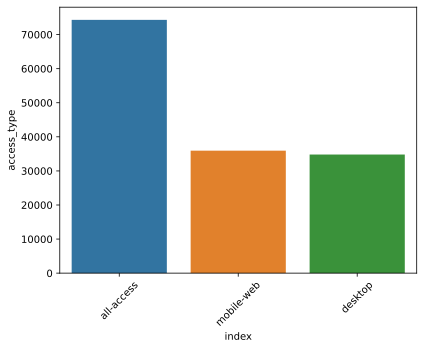

------------------------------------------------------
all-access    74315
mobile-web    35939
desktop       34809
Name: access_type, dtype: int64


In [ ]:
sns.barplot(y=df["access_type"].value_counts().nlargest(10).reset_index()['access_type'], x=df["access_type"].value_counts().nlargest(10).reset_index()['index'])
plt.xticks(rotation=45)
plt.show()
print('------------------------------------------------------')
print(df["access_type"].value_counts().nlargest(10))

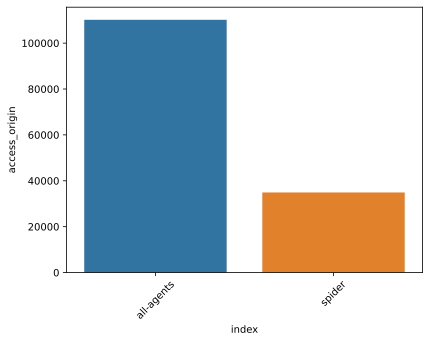

------------------------------------------------------
all-agents    110150
spider         34913
Name: access_origin, dtype: int64


In [ ]:
sns.barplot(y=df["access_origin"].value_counts().nlargest(10).reset_index()['access_origin'], x=df["access_origin"].value_counts().nlargest(10).reset_index()['index'])
plt.xticks(rotation=45)
plt.show()
print('------------------------------------------------------')
print(df["access_origin"].value_counts().nlargest(10))

In [ ]:
df.head()#lets do a language wise groupby

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,source,access_origin,access_type
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,Chinese,wikipedia,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,Chinese,wikipedia,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,Chinese,wikipedia,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,Chinese,wikipedia,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,3.0,11.0,27.0,13.0,36.0,10.0,Chinese,wikipedia,spider,all-access


In [ ]:
language_col = df.pop("Language")

# Insert the "language" column at the front
df.insert(0, "Language", language_col)

In [ ]:
source_col = df.pop("source")

# Insert the "language" column at the front
df.insert(0, "source", source_col)

In [ ]:
df.head()

,source,Language,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,access_origin,access_type
0,wikipedia,Chinese,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,...,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,spider,all-access
1,wikipedia,Chinese,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,...,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,spider,all-access
2,wikipedia,Chinese,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,...,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,spider,all-access
3,wikipedia,Chinese,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,...,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,spider,all-access
4,wikipedia,Chinese,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,...,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,spider,all-access


In [ ]:
cols_to_convert = [col for col in df.columns if col not in ['source', 'Page','Language','access_type','access_origin']]

# Convert selected columns to numeric using apply() and pd.to_numeric()
# df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric)

# # Display the resulting DataFrame with selected columns as
df[cols_to_convert] = df[cols_to_convert].astype(int)
print(df.dtypes)

source           object
Language         object
Page             object
2015-07-01        int64
2015-07-02        int64
                  ...  
2016-12-29        int64
2016-12-30        int64
2016-12-31        int64
access_origin    object
access_type      object
Length: 555, dtype: object


In [ ]:
cols=df.columns[3:]
cols=np.array(cols)[:-2]

In [ ]:
agg={i : "sum" for  i in cols}


In [ ]:
temp_df=df.drop(['source','Page','access_origin', 'access_type'],axis=1)
df_grouped=temp_df.groupby(['Language']).agg(agg)

In [ ]:
df_grouped.head(10)# we have found the total count for each day under each language


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Language,,,,,,,,,,,,,,,,,,,,,
Chinese,4135827,4142363,4115414,4155582,4433966,4455962,4450970,4567252,4539222,4719747,...,5925004,5844354,6191381,6547286,6464410,6457300,6492923,6012621,6081369,6267350
English,83476257,83224983,79079043,82422627,85120407,91686531,86720781,81755703,83634224,83224328,...,108223126,106507420,115895697,120921420,136274695,141776885,137255823,146836465,122277913,120521478
French,8429828,8484861,8156289,8720435,8560018,8919391,8622048,8463286,8374877,7903212,...,11539648,11319157,10949587,11819025,16617235,15219472,13707972,13325712,12392553,11418874
German,13113068,12971313,12458820,11423941,13276714,14599798,14155674,14367267,13848267,12908021,...,15109554,15329776,14845324,23391842,22027881,19833089,18879845,18164677,17344694,16350025
Japanese,11818687,13570229,12252427,15387963,14775371,12879611,12527093,12451654,12140944,12616427,...,13758429,19731520,17463275,16680279,15858477,16077430,16114588,17645461,19412618,24423308
Media,3045648,3059383,2841189,2588688,2759317,3028846,3115770,3196115,2984623,2920408,...,15125921,9828189,6914551,6938760,6598443,7122780,7965775,6938627,6612131,6215792
Russian,9431015,9596018,8891118,8360557,8905671,9594089,9370110,9323997,9553240,10943191,...,13379625,13209109,13035340,16361219,16463617,14868652,13840320,13368515,11978526,13095176
"Spanish, Castilian",15222146,14544690,13369898,12553144,13663908,15578006,15184927,14735637,14456738,13139153,...,13798919,13115211,12349402,12673571,16763309,15892501,16525690,15594491,11508492,11029791


In [ ]:
#lets do some basic analysis on this one:
df_grouped[cols].sum(axis=1)/10000000 # language wise visit distibution across all the days scaling it down by 10000000

Language
Chinese                316.252844
English               5749.732873
French                 633.958940
German                 872.291208
Japanese               853.672750
Media                  283.105835
Russian                795.692212
Spanish, Castilian     945.215273
dtype: float64

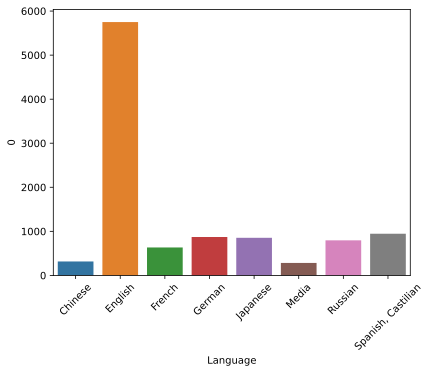

In [ ]:
temp_1=df_grouped[cols].sum(axis=1)/10000000
temp_1=temp_1.reset_index()
plt.xticks(rotation=45)
sns.barplot(x=temp_1['Language'],y=temp_1[0])
plt.show()

most viewed languages include


1.   English
2.   spanish
3.   german
4.   Japanese
5.   Russian

    



In [ ]:
from datetime import datetime
dates=[]
for date_string in cols:
    date = datetime.strptime(date_string, '%Y-%m-%d')
    dates.append(date)

In [ ]:
# lets do the ARIMA model for english first
# we need to pivot the data first
df_grouped=df_grouped.reset_index()



In [ ]:
English_ts=df_grouped[df_grouped['Language']=="English"].T.reset_index()
English_ts=English_ts.drop(0)
English_ts=English_ts.set_index('index')
English_ts.columns=['views']
English_ts

,views
index,
2015-07-01,83476257
2015-07-02,83224983
2015-07-03,79079043
2015-07-04,82422627
2015-07-05,85120407
...,...
2016-12-27,141776885
2016-12-28,137255823
2016-12-29,146836465


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

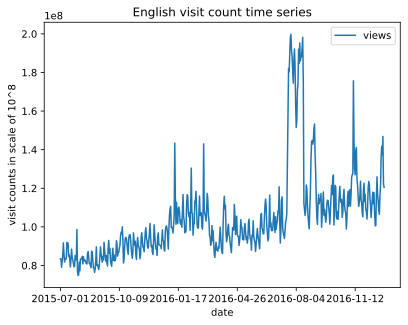

In [ ]:
#lets see the plot
English_ts.plot()
plt.ylabel("visit counts in scale of 10^8")
plt.xlabel('date')
plt.title("English visit count time series")
plt.show()

In [ ]:
English_ts=English_ts.astype(float)
max=pd.Series(English_ts.views).quantile(0.95)
min=pd.Series(English_ts.views).quantile(0.05)
max,min

(152483983.4999999, 81294772.8)

In [ ]:
English_ts.head()

,views
index,
2015-07-01,83476257.0
2015-07-02,83224983.0
2015-07-03,79079043.0
2015-07-04,82422627.0
2015-07-05,85120407.0


In [ ]:
English_ts.views = English_ts.views.clip(upper=max , lower=min)


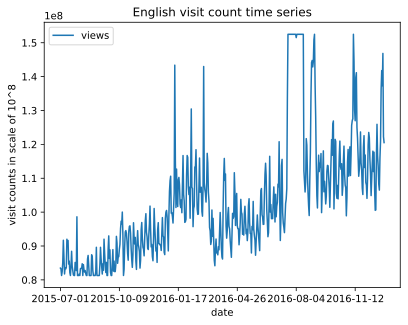

In [ ]:
#lets see the plot
English_ts.plot()
plt.ylabel("visit counts in scale of 10^8")
plt.xlabel('date')
plt.title("English visit count time series")
plt.show()

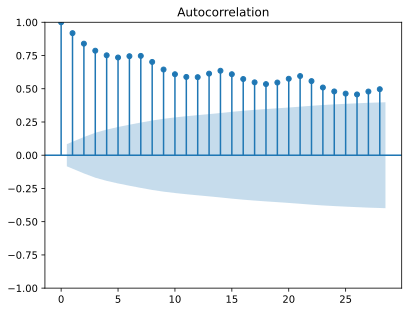

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(English_ts)
plt.show()

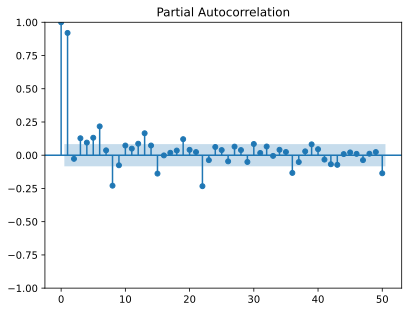

In [ ]:
plot_pacf(English_ts, lags=50)
plt.show()

from the above pacf and acf charts we can see the 95 %ile shaded region for correllation till n lags shown in x axis we can conclude that lag values of 0-15 show good correlation and it drops as we go further so p of below 15 should be tested for the ARIMA model

In [ ]:
#we first need to do the train test split we can do a 80-20 train test split
# so out of the 550 days 440 will go to train and 110 will be test
train_x = English_ts.loc[English_ts.index < English_ts.index[-110]].copy()
test_x = English_ts.loc[English_ts.index >= English_ts.index[-80]].copy()
val_x = English_ts.loc[(English_ts.index >= English_ts.index[-110]) & (English_ts.index < English_ts.index[-80])].copy()

In [ ]:
print(train_x.head(10))
print('---------------------------------')
print(test_x.head(10))
print('---------------------------------')
print(val_x.head(10))



                 views
index                 
2015-07-01  83476257.0
2015-07-02  83224983.0
2015-07-03  81294772.8
2015-07-04  82422627.0
2015-07-05  85120407.0
2015-07-06  91686531.0
2015-07-07  86720781.0
2015-07-08  81755703.0
2015-07-09  83634224.0
2015-07-10  83224328.0
---------------------------------
                  views
index                  
2016-10-13  107881534.0
2016-10-14  103916282.0
2016-10-15  110502719.0
2016-10-16  116601472.0
2016-10-17  120954896.0
2016-10-18  113566994.0
2016-10-19  112612692.0
2016-10-20  114278887.0
2016-10-21  104963628.0
2016-10-22  107380524.0
---------------------------------
                  views
index                  
2016-09-13  114451155.0
2016-09-14  113222294.0
2016-09-15  117276519.0
2016-09-16   99856807.0
2016-09-17  106004262.0
2016-09-18  112123464.0
2016-09-19  118068563.0
2016-09-20  106015745.0
2016-09-21  109085949.0
2016-09-22  106077280.0


In [ ]:
#lets define the dickey fuller test
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1]
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

adf_test(English_ts)

Sequence is not stationary


In [ ]:
English_ts.head()

,views
index,
2015-07-01,83476257.0
2015-07-02,83224983.0
2015-07-03,81294772.8
2015-07-04,82422627.0
2015-07-05,85120407.0


In [ ]:
English_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   views   550 non-null    float64
dtypes: float64(1)
memory usage: 8.6+ KB


In [ ]:
English_ts['views']=English_ts.views

In [ ]:
t=English_ts.reset_index()
t['index']=t['index'].astype(np.datetime64)


In [ ]:
t = pd.DataFrame({'data': t['views'].tolist()}, index=t['index'].tolist())


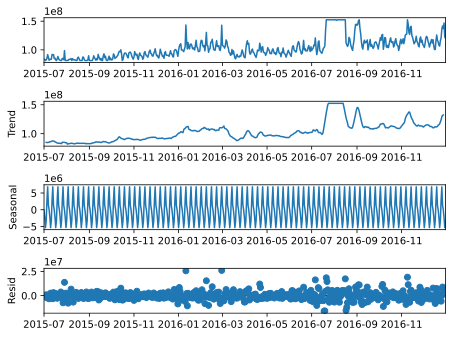

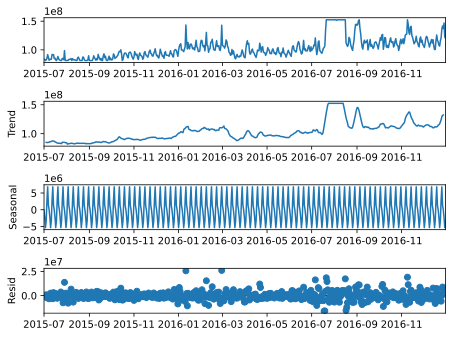

In [ ]:
# English_ts.index = pd.PeriodIndex(English_ts.index, freq='D')
model = sm.tsa.seasonal_decompose(t, model='additive')
model.plot()


The above results show us the time series decomposed into trend, seasonality and error, however we can use the raw data in our models as they already take care of this

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [ ]:
train_x=pd.DataFrame(train_x)
train_x.columns=['views']
train_x['views']=train_x['views'].astype('int')

test_x=pd.DataFrame(test_x)
test_x.columns=['views']
test_x['views']=test_x['views'].astype('int')

In [ ]:
model = SARIMAX(train_x.views, order=(2, 1, 2))
model = model.fit(disp=False)

val_x['pred'] = model.forecast(steps=30)

performance(val_x['views'], val_x['pred'])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE : 5147344.291
RMSE : 7036369.706
MAPE: 0.044


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='index'>

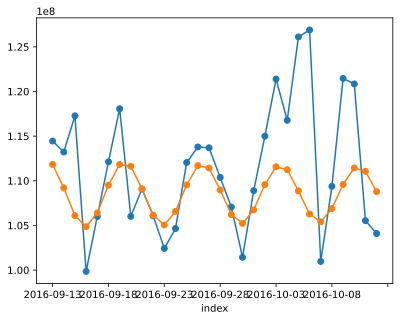

In [ ]:

val_x['views'].plot(style='-o')
val_x['pred'].plot(style='-o')


In [ ]:

def ARIMA(train ,test , p,d,q):
  dict={}
  for i in p:
      for k in q:
        order=(i,1,k)
        model = SARIMAX(train.views, order=order)
        model = model.fit(disp=False)
        pred = model.forecast(steps=30)
        error=mape(val_x.views,pred)
        dict[order]=error
  return sorted(dict.items(), key=lambda x: x[1], reverse=False)[:5]






In [ ]:
import warnings
warnings.filterwarnings("ignore")
p = [0,5,10, 15,20]
d = [0,1]
q = [0,5,10,15]
ARIMA(train_x,val_x,p,d,q)

[((5, 1, 10), 0.046823869990184584),
 ((5, 1, 5), 0.04901498366258134),
 ((5, 1, 0), 0.05329454846958947),
 ((10, 1, 0), 0.05398401896125502),
 ((0, 1, 0), 0.054329201891089605)]

In [ ]:
# the best we could get from the above training is 20,1,15
model = SARIMAX(train_x.views, order=(5, 1, 10))
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=110)

performance(test_x['views'], test_x['pred'])

MAE : 8007396.24
RMSE : 12043237.879
MAPE: 0.064


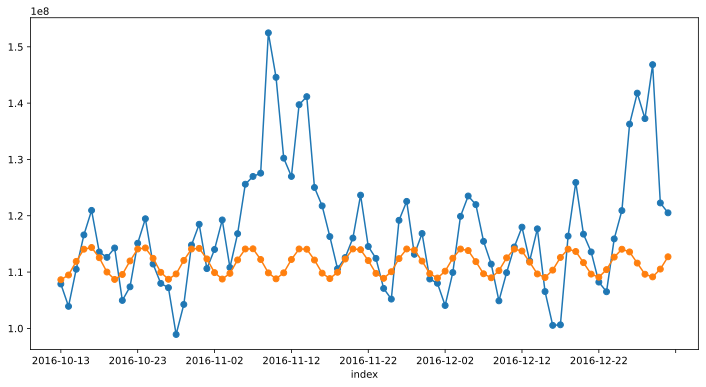

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the two series with the style -o
test_x['views'].plot(style='-o')
test_x['pred'].plot(style='-o')

# Display the plot
plt.show()

In [ ]:

df_exog['date']=cols

In [ ]:
df_exog.set_index('date',inplace=True)
df_exog.head()

,Exog
date,
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
2015-07-05,0


MAE : 5098274.195
RMSE : 6874657.253
MAPE: 0.045


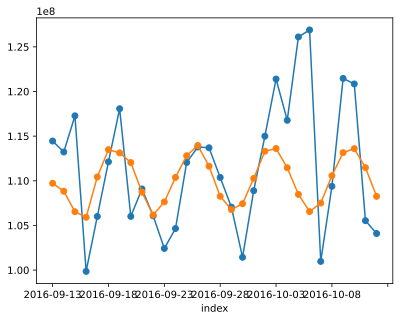

In [ ]:
# using the exog
exog_train=df_exog['Exog'][:-110]
exog_test=df_exog['Exog'][-110:-80]
model = SARIMAX(train_x.views, order=(5, 1, 10), exog= exog_train )
model = model.fit(disp=False)

val_x['pred'] = model.forecast(steps=30,exog=exog_test)

val_x['views'].plot(style='-o')
val_x['pred'].plot(style='-o')
performance(val_x['views'], val_x['pred'])

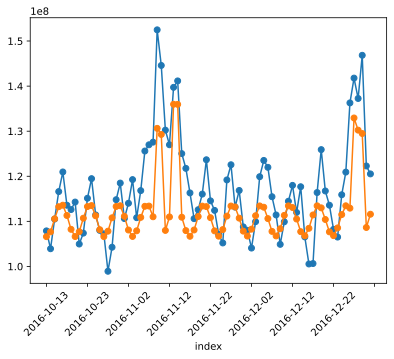

MAE : 6541962.705
RMSE : 8538652.331
MAPE: 0.054


In [ ]:
exog_test=df_exog['Exog'][-110:]
test_x['pred'] = model.forecast(steps=110,exog=exog_test)

test_x['views'].plot(style='-o')
test_x['pred'].plot(style='-o')
plt.xticks(rotation=45)
plt.show()
performance(test_x['views'], test_x['pred'])

The EXOg feature significantly improved the MAPE using SARIMAX model from 6.4 % to 5.4 %
we dont have exog features for other languages still we can see how it performs using the same exog


In [ ]:
# lets create a function which creates a ARIMA model and prints the performance:
def SARIMA_exog(df_grouped,lang):
  ts=df_grouped[df_grouped['Language']==lang].T.reset_index()
  ts=ts.drop(0)
  ts=ts.set_index('index')
  ts.columns=['views']
  # the above code creates time series
  ts=ts.astype(float)
  max=pd.Series(ts.views).quantile(0.95)
  min=pd.Series(ts.views).quantile(0.05)
  ts.views = ts.views.clip(upper=max , lower=min)
  # clips data at 95% and 5 %
  train_x = ts.loc[ts.index < ts.index[-110]].copy()
  test_x = ts.loc[ts.index >= ts.index[-110]].copy()
  # val_x = English_ts.loc[(English_ts.index >= English_ts.index[-110]) & (English_ts.index < English_ts.index[-80])].copy()
  #train test split
  exog_train=df_exog['Exog'][:-110]
  exog_test=df_exog['Exog'][-110:]
  model = SARIMAX(train_x.views, order=(5, 1, 10),exog=exog_train)
  model = model.fit(disp=False)

  test_x['pred'] = model.forecast(steps=110,exog=exog_test)
  perfor={}
  perfor['SARIMA']= mape(test_x['views'], test_x['pred'])
  return perfor

In [ ]:
#lets use ARIMA and find out the MAPE for all languages
list_of_lang=df_grouped['Language'].tolist()
if 'English' in list_of_lang:
    list_of_lang.remove('English')
for i in list_of_lang:
  print(f"MAPE for {i} is {SARIMA_exog(df_grouped,lang=i)}")

MAPE for Chinese is {'ARIMA': 0.046346676250202126}
MAPE for French is {'ARIMA': 0.0707863724175673}
MAPE for German is {'ARIMA': 0.08839844994935586}
MAPE for Japanese is {'ARIMA': 0.07397115218460808}
MAPE for Media is {'ARIMA': 0.10681133641997714}
MAPE for Russian is {'ARIMA': 0.09231603349962787}
MAPE for Spanish, Castilian is {'ARIMA': 0.14196065304985267}


We dont see much difference between the models using SARIMAX with exog variable from the ARIMA model as the exog is not relevant for other languages

In [ ]:
# lets create a function which creates a ARIMA model and prints the performance:
def ARIMA_p(df_grouped,lang):
  ts=df_grouped[df_grouped['Language']==lang].T.reset_index()
  ts=ts.drop(0)
  ts=ts.set_index('index')
  ts.columns=['views']
  # the above code creates time series
  ts=ts.astype(float)
  max=pd.Series(ts.views).quantile(0.95)
  min=pd.Series(ts.views).quantile(0.05)
  ts.views = ts.views.clip(upper=max , lower=min)
  # clips data at 95% and 5 %
  train_x = ts.loc[ts.index < ts.index[-110]].copy()
  test_x = ts.loc[ts.index >= ts.index[-110]].copy()
  # val_x = English_ts.loc[(English_ts.index >= English_ts.index[-110]) & (English_ts.index < English_ts.index[-80])].copy()
  #train test split
  model = SARIMAX(train_x.views, order=(5, 1, 10))
  model = model.fit(disp=False)

  test_x['pred'] = model.forecast(steps=110)
  perfor={}
  perfor['ARIMA']= mape(test_x['views'], test_x['pred'])
  return perfor





In [ ]:
#lets use ARIMA and find out the MAPE for all languages

for i in list_of_lang:
  print(f"MAPE for {i} is {ARIMA_p(df_grouped,lang=i)}")


MAPE for Chinese is {'ARIMA': 0.04624829286256366}
MAPE for French is {'ARIMA': 0.07134738065842706}
MAPE for German is {'ARIMA': 0.08646154202515116}
MAPE for Japanese is {'ARIMA': 0.07436881137596187}
MAPE for Media is {'ARIMA': 0.10724966580646565}
MAPE for Russian is {'ARIMA': 0.10657350035538671}
MAPE for Spanish, Castilian is {'ARIMA': 0.1450160331941152}


In [ ]:
import io, os, sys, setuptools, tokenize
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#lets try prophet
from prophet import Prophet
profet_df=train_x.reset_index()

profet_df = profet_df.rename(columns={'index': 'ds', 'views': 'y'})

In [ ]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(profet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2wfuwgt6/zig06_bc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2wfuwgt6/qf4b624g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42298', 'data', 'file=/tmp/tmp2wfuwgt6/zig06_bc.json', 'init=/tmp/tmp2wfuwgt6/qf4b624g.json', 'output', 'file=/tmp/tmp2wfuwgt6/prophet_modelxr58nm8k/prophet_model-20230421130545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:05:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future=model.make_future_dataframe(periods=110)
forecast = model.predict(future)


In [ ]:
test_x['pred']=forecast[-80:]['yhat'].to_list()
train_x['pred']=forecast[:-110]['yhat'].to_list()

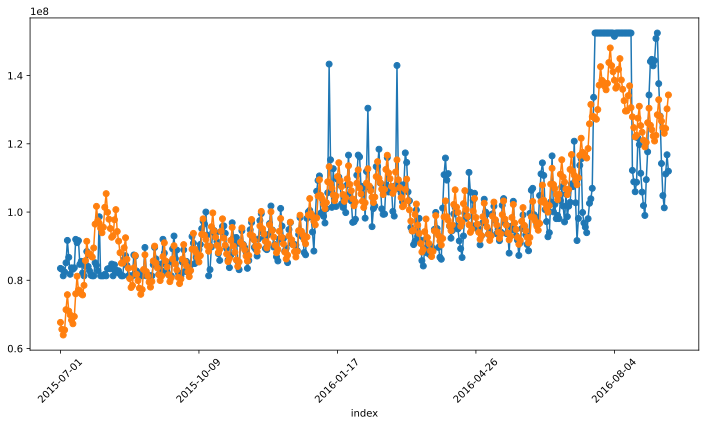

MAE : 6138115.826
RMSE : 8856101.389
MAPE: 0.059


In [ ]:
plt.figure(figsize=(12, 6))

train_x['views'].plot(style='-o')
train_x['pred'].plot(style='-o')
plt.xticks(rotation=45)
plt.show()
performance(train_x['views'], train_x['pred'])

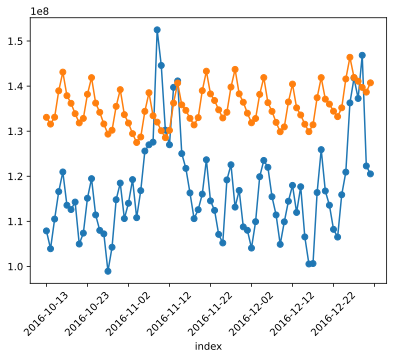

MAE : 19498599.856
RMSE : 20833703.583
MAPE: 0.172


In [ ]:
test_x['views'].plot(style='-o')
test_x['pred'].plot(style='-o')
plt.xticks(rotation=45)
plt.show()
performance(test_x['views'], test_x['pred'])

The first trail profet has 6 % MAPE using train data but test scores are 17% whis is not usable.

In [ ]:
# we can check the mape for other languages using prophet
# lets create a function which creates a ARIMA model and prints the performance:
def profet(df_grouped,lang):
  ts=df_grouped[df_grouped['Language']==lang].T.reset_index()
  ts=ts.drop(0)
  ts=ts.set_index('index')
  ts.columns=['views']
  # the above code creates time series
  ts=ts.astype(float)
  max=pd.Series(ts.views).quantile(0.95)
  min=pd.Series(ts.views).quantile(0.05)
  ts.views = ts.views.clip(upper=max , lower=min)
  # clips data at 95% and 5 %
  train_x = ts.loc[ts.index < ts.index[-110]].copy()
  test_x = ts.loc[ts.index >= ts.index[-110]].copy()
  # val_x = English_ts.loc[(English_ts.index >= English_ts.index[-110]) & (English_ts.index < English_ts.index[-80])].copy()
  #train test split
  profet_df=train_x.reset_index()

  profet_df = profet_df.rename(columns={'index': 'ds', 'views': 'y'})
  model = Prophet(yearly_seasonality=True, daily_seasonality=True)
  model.fit(profet_df)
  future=model.make_future_dataframe(periods=110)
  forecast = model.predict(future)
  test_x['pred'] = test_x['pred']=forecast[-110:]['yhat'].to_list()
  perfor={}
  perfor['prophet']= mape(test_x['views'], test_x['pred'])
  return perfor


In [ ]:
final_profet_MAPE={}
for i in list_of_lang:
  final_profet_MAPE[i]=profet(df_grouped,i)



In [ ]:
final_profet_MAPE

{'Chinese': {'prophet': 0.0894898476421958},
 'French': {'prophet': 0.09517354648132867},
 'German': {'prophet': 0.06366584982736467},
 'Japanese': {'prophet': 0.1151293164097301},
 'Media': {'prophet': 0.20160234464303822},
 'Russian': {'prophet': 0.2841092794635287},
 'Spanish, Castilian': {'prophet': 0.0691709279967693}}

The scores using prophet without any features are shown above it is around 6.3-28% percentage it seems o produce good results with German, spanish and chinese  language